In [ ]:
import numpy as np
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torchvision
import torchvision.datasets as datasets

from matplotlib import pyplot as plt
from numpy import save, load

In [ ]:
"""Define internal NN module that trains on the dataset"""
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        self.relu5 = nn.ReLU()

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        return y

In [ ]:
"""Define internal NN module that trains on the dataset"""
class EasyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 2048)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(2048, 10)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        y = x.view(x.shape[0], -1)
        y = self.fc1(y)
        y = self.relu1(y)
        y = self.fc2(y)
        y = self.relu2(y)
        return y

In [ ]:
"""Make toy dataset"""

def create_toy(train_dataset, test_dataset, batch_size, n_samples):
    
    # shuffle and take first n_samples %age of training dataset
    shuffle_order_train = np.random.RandomState(seed=100).permutation(len(train_dataset))
    shuffled_train_dataset = torch.utils.data.Subset(train_dataset, shuffle_order_train)
    indices_train = torch.arange(int(n_samples*len(train_dataset)))
    reduced_train_dataset = data_utils.Subset(shuffled_train_dataset, indices_train)

    # shuffle and take first n_samples %age of test dataset
    shuffle_order_test = np.random.RandomState(seed=1000).permutation(len(test_dataset))
    shuffled_test_dataset = torch.utils.data.Subset(test_dataset, shuffle_order_test)
    indices_test = torch.arange(int(n_samples*len(test_dataset)))
    reduced_test_dataset = data_utils.Subset(shuffled_test_dataset, indices_test)

    # push into DataLoader
    train_loader = torch.utils.data.DataLoader(reduced_train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(reduced_test_dataset, batch_size=batch_size)

    return train_loader, test_loader

In [ ]:
"""Randomly generate 10 policies"""
"""Each policy has 5 sub-policies"""
"""For each sub-policy, pick 2 transformations, 2 probabilities and 2 magnitudes"""

def generate_policies(num_policies, num_sub_policies):
    
    policies = np.zeros([num_policies,num_sub_policies,6])

    # Policies array will be 10x5x6
    for policy in range(num_policies):
        for sub_policy in range(num_sub_policies):
            # pick two sub_policy transformations (0=rotate, 1=shear, 2=scale)
            policies[policy, sub_policy, 0] = np.random.randint(0,3)
            policies[policy, sub_policy, 1] = np.random.randint(0,3)
            while policies[policy, sub_policy, 0] == policies[policy, sub_policy, 1]:
                policies[policy, sub_policy, 1] = np.random.randint(0,3)

            # pick probabilities
            policies[policy, sub_policy, 2] = np.random.randint(0,11) / 10
            policies[policy, sub_policy, 3] = np.random.randint(0,11) / 10

            # pick magnitudes
            for transformation in range(2):
                if policies[policy, sub_policy, transformation] <= 1:
                    policies[policy, sub_policy, transformation + 4] = np.random.randint(-4,5)*5
                elif policies[policy, sub_policy, transformation] == 2:
                    policies[policy, sub_policy, transformation + 4] = np.random.randint(5,15)/10

    return policies

In [ ]:
"""Pick policy and sub-policy"""
"""Each row of data should have a different sub-policy but for now, this will do"""

def sample_sub_policy(policies, policy, num_sub_policies):
    sub_policy = np.random.randint(0,num_sub_policies)

    degrees = 0
    shear = 0
    scale = 1

    # check for rotations
    if policies[policy, sub_policy][0] == 0:
        if np.random.uniform() < policies[policy, sub_policy][2]:
            degrees = policies[policy, sub_policy][4]
    elif policies[policy, sub_policy][1] == 0:
        if np.random.uniform() < policies[policy, sub_policy][3]:
            degrees = policies[policy, sub_policy][5]

    # check for shears
    if policies[policy, sub_policy][0] == 1:
        if np.random.uniform() < policies[policy, sub_policy][2]:
            shear = policies[policy, sub_policy][4]
    elif policies[policy, sub_policy][1] == 1:
        if np.random.uniform() < policies[policy, sub_policy][3]:
            shear = policies[policy, sub_policy][5]

    # check for scales
    if policies[policy, sub_policy][0] == 2:
        if np.random.uniform() < policies[policy, sub_policy][2]:
            scale = policies[policy, sub_policy][4]
    elif policies[policy, sub_policy][1] == 2:
        if np.random.uniform() < policies[policy, sub_policy][3]:
            scale = policies[policy, sub_policy][5]

    return degrees, shear, scale

In [ ]:
"""Sample policy, open and apply above transformations"""
def run_UCB1(policies, batch_size, toy_size, max_epochs, early_stop_num, iterations, IsLeNet):

    # get number of policies and sub-policies
    num_policies = len(policies)
    num_sub_policies = len(policies[0])

    #Initialize vector weights, counts and regret
    q_values = [0]*num_policies
    cnts = [0]*num_policies
    q_plus_cnt = [0]*num_policies
    total_count = 0

    best_q_values = []

    for policy in range(iterations):

        # get the action to try (either initially in order or using best q_plus_cnt value)
        if policy >= num_policies:
            this_policy = np.argmax(q_plus_cnt)
        else:
            this_policy = policy

        # get info of transformation for this sub-policy
        degrees, shear, scale = sample_sub_policy(policies, this_policy, num_sub_policies)

        # create transformations using above info
        transform = torchvision.transforms.Compose(
            [torchvision.transforms.RandomAffine(degrees=(degrees,degrees), shear=(shear,shear), scale=(scale,scale)),
            torchvision.transforms.ToTensor()])

        # open data and apply these transformations
        train_dataset = datasets.MNIST(root='./MetaAugment/train', train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root='./MetaAugment/test', train=False, download=True, transform=transform)

        # create toy dataset from above uploaded data
        train_loader, test_loader = create_toy(train_dataset, test_dataset, batch_size, toy_size)

        # create model
        if IsLeNet:
            model = LeNet()
        else:
            model = EasyNet()
        sgd = optim.SGD(model.parameters(), lr=1e-1)
        cost = nn.CrossEntropyLoss()

        # set variables for best validation accuracy and early stop count
        best_acc = 0
        early_stop_cnt = 0

        # train model and check validation accuracy each epoch
        for _epoch in range(max_epochs):

            # train model
            model.train()
            for idx, (train_x, train_label) in enumerate(train_loader):
                label_np = np.zeros((train_label.shape[0], 10))
                sgd.zero_grad()
                predict_y = model(train_x.float())
                loss = cost(predict_y, train_label.long())
                loss.backward()
                sgd.step()

            # check validation accuracy on validation set
            correct = 0
            _sum = 0
            model.eval()
            for idx, (test_x, test_label) in enumerate(test_loader):
                predict_y = model(test_x.float()).detach()
                predict_ys = np.argmax(predict_y, axis=-1)
                label_np = test_label.numpy()
                _ = predict_ys == test_label
                correct += np.sum(_.numpy(), axis=-1)
                _sum += _.shape[0]
            
            # update best validation accuracy if it was higher, otherwise increase early stop count
            acc = correct / _sum
            if acc > best_acc :
                best_acc = acc
                early_stop_cnt = 0
            else:
                early_stop_cnt += 1

            # exit if validation gets worse over 10 runs
            if early_stop_cnt >= early_stop_num:
                break

        # update q_values
        if policy < num_policies:
            q_values[this_policy] += best_acc
        else:
            q_values[this_policy] = (q_values[this_policy]*cnts[this_policy] + best_acc) / (cnts[this_policy] + 1)

        best_q_value = max(q_values)
        best_q_values.append(best_q_value)

        if (policy+1) % 10 == 0:
            print("Iteration: {},\tQ-Values: {}, Best Policy: {}".format(policy+1, list(np.around(np.array(q_values),2)), max(list(np.around(np.array(q_values),2)))))

        # update counts
        cnts[this_policy] += 1
        total_count += 1

        # update q_plus_cnt values every turn after the initial sweep through
        if policy >= num_policies - 1:
            for i in range(num_policies):
                q_plus_cnt[i] = q_values[i] + np.sqrt(2*np.log(total_count)/cnts[i])

    return q_values, best_q_values

Iteration: 10,	Q-Values: [0.79, 0.85, 0.87, 0.69, 0.83], Best Policy: 0.87
Iteration: 20,	Q-Values: [0.82, 0.86, 0.88, 0.82, 0.86], Best Policy: 0.88
Iteration: 30,	Q-Values: [0.84, 0.89, 0.77, 0.84, 0.87], Best Policy: 0.89
Iteration: 40,	Q-Values: [0.83, 0.9, 0.83, 0.84, 0.89], Best Policy: 0.9
Iteration: 50,	Q-Values: [0.84, 0.91, 0.82, 0.85, 0.87], Best Policy: 0.91
Iteration: 60,	Q-Values: [0.83, 0.92, 0.83, 0.86, 0.88], Best Policy: 0.92
Iteration: 70,	Q-Values: [0.84, 0.92, 0.83, 0.85, 0.88], Best Policy: 0.92
Iteration: 80,	Q-Values: [0.85, 0.92, 0.83, 0.85, 0.87], Best Policy: 0.92
Iteration: 90,	Q-Values: [0.85, 0.91, 0.81, 0.85, 0.87], Best Policy: 0.91
Iteration: 100,	Q-Values: [0.84, 0.91, 0.83, 0.85, 0.83], Best Policy: 0.91


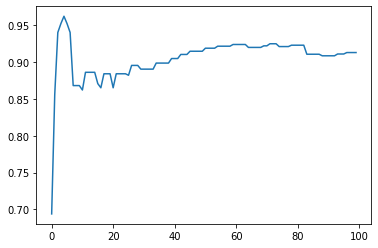

In [ ]:
batch_size = 32       # size of batch the inner NN is trained with
toy_size = 0.05       # total propeortion of training and test set we use
max_epochs = 100      # max number of epochs that is run if early stopping is not hit
early_stop_num = 10   # max number of worse validation scores before early stopping is triggered
num_policies = 5      # fix number of policies
num_sub_policies = 5  # fix number of sub-policies in a policy
iterations = 100      # total iterations, should be more than the number of policies
IsLeNet = True        # using LeNet or EasyNet

# generate random policies at start
policies = generate_policies(num_policies, num_sub_policies)

q_values, best_q_values = run_UCB1(policies, batch_size, toy_size, max_epochs, early_stop_num, iterations, IsLeNet)

plt.plot(best_q_values)

best_q_values = np.array(best_q_values)
save('best_q_values_LeNet_5percent.npy', best_q_values)
#best_q_values = load('best_q_values_LeNet_5percent.npy', allow_pickle=True)